## I&I

In [2]:
import ipywidgets as widgets
import os
import sys
import skimage.io
import scipy
import json

In [3]:
with open('json_config.json') as f:
    json_conf = json.load(f)

In [4]:

ROOT_DIR = os.path.abspath(json_conf['ssd_folder']) # add here mask RCNN path
sys.path.append(ROOT_DIR)

import cv2
from utils_ssd import *
import pandas as pd
from PIL import Image

from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
% autoreload 2

/home/gidi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
data_folder = json_conf['data_folder']

### SVHN parsing

In [7]:
def read_process_h5(filename):
    """ Reads and processes the mat files provided in the SVHN dataset. 
        Input: filename 
        Ouptut: list of python dictionaries 
    """ 
        
    f = h5py.File(filename, 'r')
    groups = list(f['digitStruct'].items())
    bbox_ds = np.array(groups[0][1]).squeeze()
    names_ds = np.array(groups[1][1]).squeeze()

    data_list = []
    num_files = bbox_ds.shape[0]
    count = 0

    for objref1, objref2 in zip(bbox_ds[:10000], names_ds[:10000]):

        data_dict = {}

        # Extract image name
        names_ds = np.array(f[objref2]).squeeze()
        filename = ''.join(chr(x) for x in names_ds)
        data_dict['filename'] = filename

        #print filename

        # Extract other properties
        items1 = list(f[objref1].items())

        # Extract image label
        labels_ds = np.array(items1[1][1]).squeeze()
        try:
            label_vals = [int(f[ref][:][0, 0]) for ref in labels_ds]
        except TypeError:
            label_vals = [labels_ds]
        data_dict['labels'] = label_vals
        data_dict['length'] = len(label_vals)

        # Extract image height
        height_ds = np.array(items1[0][1]).squeeze()
        try:
            height_vals = [f[ref][:][0, 0] for ref in height_ds]
        except TypeError:
            height_vals = [height_ds]
        data_dict['height'] = height_vals

        # Extract image left coords
        left_ds = np.array(items1[2][1]).squeeze()
        try:
            left_vals = [f[ref][:][0, 0] for ref in left_ds]
        except TypeError:
            left_vals = [left_ds]
        data_dict['left'] = left_vals

        # Extract image top coords
        top_ds = np.array(items1[3][1]).squeeze()
        try:
            top_vals = [f[ref][:][0, 0] for ref in top_ds]
        except TypeError:
            top_vals = [top_ds]
        data_dict['top'] = top_vals

        # Extract image width
        width_ds = np.array(items1[4][1]).squeeze()
        try:
            width_vals = [f[ref][:][0, 0] for ref in width_ds]
        except TypeError:
            width_vals = [width_ds]
        data_dict['width'] = width_vals

        data_list.append(data_dict)

        count += 1
        print ('Processed: %d/%d' % (count, num_files))

    return data_list

def json_to_pascal(json, filename):
    # convert json to pascal and save as csv
    pascal_list = []
    for i in json:
        for j in range(len(i['labels'])):
            pascal_list.append({'fname': i['filename'] 
            ,'xmin': int(i['left'][j]), 'xmax': int(i['left'][j]+i['width'][j])
            ,'ymin': int(i['top'][j]),  'ymax': int(i['top'][j]+i['height'][j])
            ,'class_id': int(i['labels'][j])})
    df_pascal = pd.DataFrame(pascal_list,dtype='str')
    df_pascal.to_csv(filename,index=False)

In [8]:
file_path = data_folder+'/digitStruct.mat'

In [10]:
p  = read_process_h5(file_path)

In [12]:
data_folder

'/media/gidi/cf8dba8d-79f9-4bca-9076-1ddb14211382/svhn/test'

In [11]:
json_to_pascal(p, data_folder+'/pascal.csv')

##  Debug

In [21]:
def viz_random_image(df):
    file = np.random.choice(df.fname)
    im = skimage.io.imread(data_folder+file)
    annots =  df[df.fname==file].iterrows()

    plt.figure(figsize=(6,6))
    plt.imshow(im)

    current_axis = plt.gca()

    for box in annots:
        label = box[1]['class_id']
        current_axis.add_patch(plt.Rectangle(
            (box[1]['xmin'], box[1]['ymin']), box[1]['xmax']-box[1]['xmin'],
            box[1]['ymax']-box[1]['ymin'], color='blue', fill=False, linewidth=2))  
        current_axis.text(box[1]['xmin'], box[1]['ymin'], label, size='x-large', color='white', bbox={'facecolor':'blue', 'alpha':1.0})
    plt.show()    

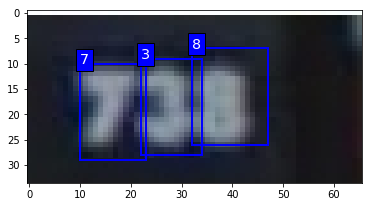

In [22]:
viz_random_image(df)

## Load the trained weights file and make a copy

### Init model

In [7]:


task = 'svhn'

labels_path = f'{data_folder}pascal.csv'

input_format = ['class_id','image_name','xmax','xmin','ymax','ymin' ]
    
df = pd.read_csv(labels_path)


In [13]:
class SVHN_Config(Config):
    batch_size = 8
    
    dataset_folder = data_folder
    task = task
    
    labels_path = labels_path

    input_format = input_format

conf=SVHN_Config()

resize = Resize(height=conf.img_height, width=conf.img_width)
trans = [resize]

In [15]:
learner = SSD_finetune(conf)
learner.get_data(create_subset=True)

weights_destination_path=learner.init_weights()

learner.get_model(mode='training', weights_path = weights_destination_path)
model = learner.model
learner.get_input_encoder()
ssd_input_encoder = learner.ssd_input_encoder

# Training schedule definitions
adam = Adam(lr=0.0002, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) 
ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)
model.compile(optimizer=adam, loss=ssd_loss.compute_loss)


data loading and preperations
class_ids [ 0  1  2  3  4  5  6  7  8  9 10]  should be numeric
input format: ['class_id', 'image_name', 'xmax', 'xmin', 'ymax', 'ymin']
   class_id  fname  xmax  xmin  ymax  ymin
0         4  1.png    62    24   126    70
1         7  1.png    91    55    97    41
Create subset of 20 files in /home/gidi/data/extra/small_pascal.csv
split to 8000  train files 2000  val files

loading weights
classes are: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
last layer indicies [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253]
Shape of the 'conv4_3_norm_mbox_conf' weights:

kernel:	 (3, 3, 512, 44)
bias:	 (44,)
Loading weights from /home/gidi/models/VGG_coco_SSD_300x300_iter_400000.h5_subsampled_11_classes.h5
created encoder with 10 classes


### Data loaders From utils

In [16]:
train_annotation_file=f'{conf.dataset_folder}train_pascal.csv'
val_annotation_file=f'{conf.dataset_folder}val_pascal.csv'
subset_annotation_file=f'{conf.dataset_folder}small_pascal.csv'


In [18]:
train_generator = learner.get_generator(conf.batch_size, trans=trans, anot_file=train_annotation_file,
                  encoder=ssd_input_encoder)

val_generator = learner.get_generator(conf.batch_size,trans=trans, anot_file=val_annotation_file,
                 returns={'processed_images','encoded_labels'}, encoder=ssd_input_encoder,val=True)



Loaded 8000 images, with [<data_generator.object_detection_2d_geometric_ops.Resize object at 0x7ff84480f7f0>] transformations
Loaded 2000 images, with [<data_generator.object_detection_2d_geometric_ops.Resize object at 0x7ff84480f7f0>] transformations


## Train

In [19]:
learner.init_training()

changing


Epoch 1/80
 99/100 [============================>.] - ETA: 0s - loss: 7.5874Epoch 00000: val_loss improved from inf to 7.04152, saving model to ./logs/ssd_20181020T0927_svhn_classes_10-00_loss-7.5827            _val_loss-7.0415.h5


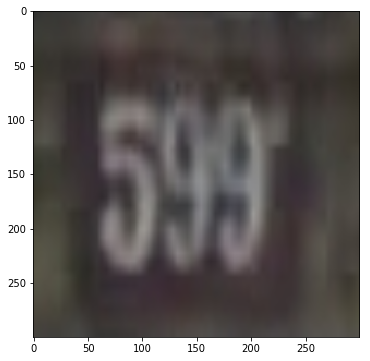

100/100 [==============================] - 40s - loss: 7.5827 - val_loss: 7.0415
Epoch 2/80
 99/100 [============================>.] - ETA: 0s - loss: 6.6095Epoch 00001: val_loss improved from 7.04152 to 6.48973, saving model to ./logs/ssd_20181020T0927_svhn_classes_10-01_loss-6.6071            _val_loss-6.4897.h5


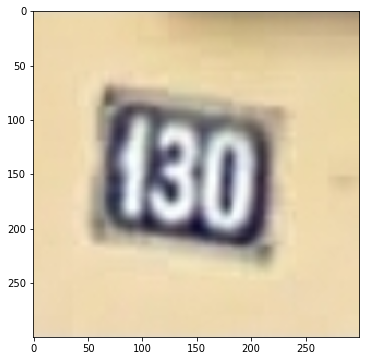

100/100 [==============================] - 24s - loss: 6.6071 - val_loss: 6.4897
Epoch 3/80
 99/100 [============================>.] - ETA: 0s - loss: 6.0514Epoch 00002: val_loss improved from 6.48973 to 6.13927, saving model to ./logs/ssd_20181020T0927_svhn_classes_10-02_loss-6.0516            _val_loss-6.1393.h5


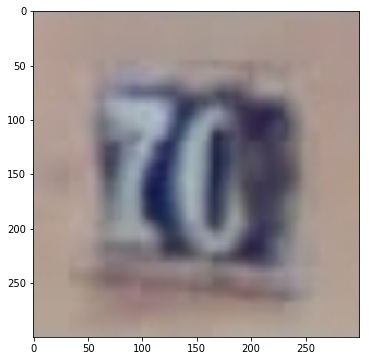

100/100 [==============================] - 24s - loss: 6.0516 - val_loss: 6.1393
Epoch 4/80
 99/100 [============================>.] - ETA: 0s - loss: 5.6588Epoch 00003: val_loss improved from 6.13927 to 5.69829, saving model to ./logs/ssd_20181020T0927_svhn_classes_10-03_loss-5.6637            _val_loss-5.6983.h5


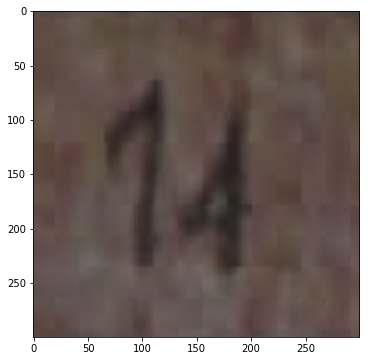

100/100 [==============================] - 24s - loss: 5.6637 - val_loss: 5.6983
Epoch 5/80
 99/100 [============================>.] - ETA: 0s - loss: 5.3728Epoch 00004: val_loss improved from 5.69829 to 5.39932, saving model to ./logs/ssd_20181020T0927_svhn_classes_10-04_loss-5.3695            _val_loss-5.3993.h5


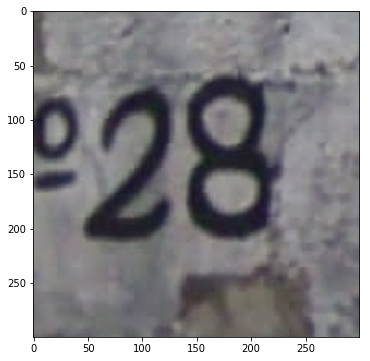

100/100 [==============================] - 24s - loss: 5.3695 - val_loss: 5.3993
Epoch 6/80
 99/100 [============================>.] - ETA: 0s - loss: 5.1709Epoch 00005: val_loss improved from 5.39932 to 5.10974, saving model to ./logs/ssd_20181020T0927_svhn_classes_10-05_loss-5.1785            _val_loss-5.1097.h5


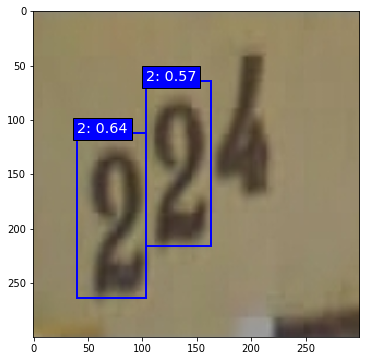

100/100 [==============================] - 24s - loss: 5.1785 - val_loss: 5.1097
Epoch 7/80
 99/100 [============================>.] - ETA: 0s - loss: 4.9706Epoch 00006: val_loss improved from 5.10974 to 4.85505, saving model to ./logs/ssd_20181020T0927_svhn_classes_10-06_loss-4.9696            _val_loss-4.8550.h5


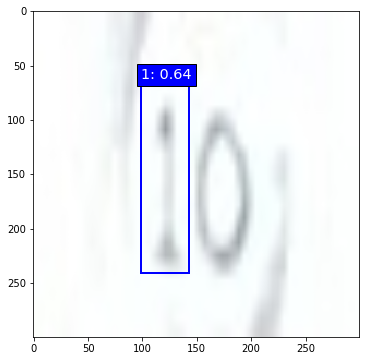

100/100 [==============================] - 24s - loss: 4.9696 - val_loss: 4.8550
Epoch 8/80
 99/100 [============================>.] - ETA: 0s - loss: 4.7608Epoch 00007: val_loss improved from 4.85505 to 4.15754, saving model to ./logs/ssd_20181020T0927_svhn_classes_10-07_loss-4.7622            _val_loss-4.1575.h5


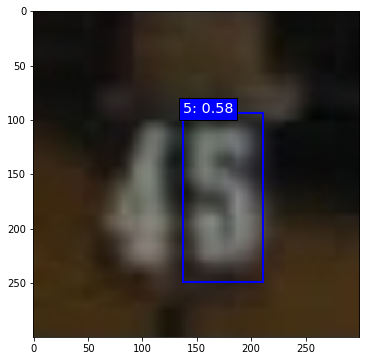

100/100 [==============================] - 24s - loss: 4.7622 - val_loss: 4.1575
Epoch 9/80
 99/100 [============================>.] - ETA: 0s - loss: 4.5393Epoch 00008: val_loss did not improve


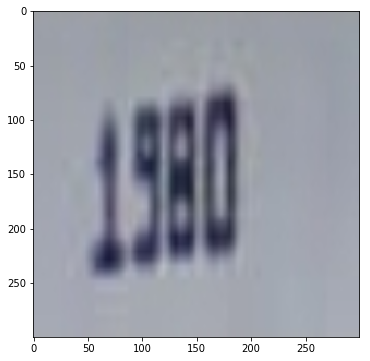

100/100 [==============================] - 24s - loss: 4.5346 - val_loss: 4.3763
Epoch 10/80
 99/100 [============================>.] - ETA: 0s - loss: 4.4258Epoch 00009: val_loss did not improve


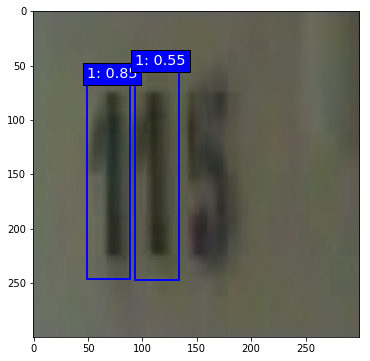

100/100 [==============================] - 24s - loss: 4.4262 - val_loss: 4.2999
Epoch 11/80
 99/100 [============================>.] - ETA: 0s - loss: 4.1440Epoch 00010: val_loss improved from 4.15754 to 4.12975, saving model to ./logs/ssd_20181020T0927_svhn_classes_10-10_loss-4.1509            _val_loss-4.1297.h5


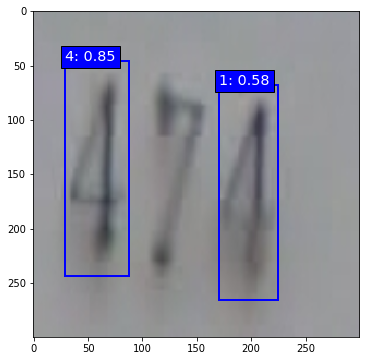

100/100 [==============================] - 24s - loss: 4.1509 - val_loss: 4.1297
Epoch 12/80
 99/100 [============================>.] - ETA: 0s - loss: 4.0620Epoch 00011: val_loss did not improve


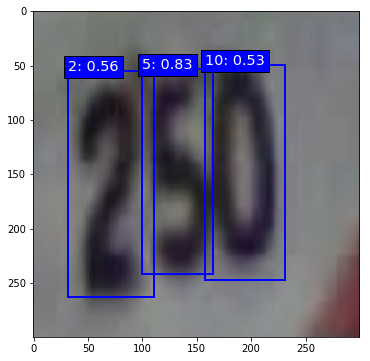

100/100 [==============================] - 24s - loss: 4.0655 - val_loss: 4.2053
Epoch 13/80
 30/100 [========>.....................] - ETA: 14s - loss: 3.9382

KeyboardInterrupt: 

In [20]:
histroy = learner.train(train_generator, val_generator, steps=100,epochs=80)
# normal training should go from dozens to ~10 in 1 epoch
#some times the models stalls and then is released :o

## Eval MAP (optional)

In [ ]:
from eval_utils.average_precision_evaluator import Evaluator

In [19]:
# evaluate map. may need some work
class_count = 10
ev = Evaluator(learner.model,class_count, test_dataset,model_mode='training' )
./logs/ssd_20181009T1927_data_classes_1-01_loss-2.7496_val_loss-2.9780.h5
map=ev(300,300,1,data_generator_mode='resize')
map

Number of images in the evaluation dataset: 2000


Producing predictions batch-wise:  49%|████▉     | 979/2000 [00:21<00:21, 48.16it/s]


Producing predictions batch-wise: 100%|█████████▉| 1991/2000 [00:42<00:00, 48.46it/s]


  0%|          | 0/6851 [00:00<?, ?it/s]
Matching predictions to ground truth, class 1/10.:   0%|          | 0/6851 [00:00<?, ?it/s]
Matching predictions to ground truth, class 1/10.:  17%|█▋        | 1132/6851 [00:00<00:00, 11317.18it/s]
Matching predictions to ground truth, class 1/10.:  37%|███▋      | 2557/6851 [00:00<00:00, 12061.92it/s]
Matching predictions to ground truth, class 1/10.:  62%|██████▏   | 4274/6851 [00:00<00:00, 13242.49it/s]
Matching predictions to ground truth, class 1/10.:  88%|████████▊ | 6018/6851 [00:00<00:00, 14269.75it/s]
Matching predictions to ground truth, class 1/10.: 100%|██████████| 6851/6851 [00:00<00:00, 15386.57it/s]
  0%|          | 0/2763 [00:00<?, ?it/s]
Matching predictions to ground truth, class 2/10.:   0%|          | 0/2763 [00:00<?, ?it/s]
Matching predictions to ground truth, class 2/10.:  51%|█████     | 1408/2763 [00:00<00:00, 14076.39it/s]
Matching predictions to ground truth, class 2/10.: 100%|██████████| 2763/2763 [00:00<00:00, 15835.

0.8230758322884167